In [70]:
from bs4 import BeautifulSoup
import requests
import pandas
from datetime import datetime
import urllib3
import matplotlib.pyplot as plt
import pylab


year = "2022"
url = f"https://www.boxofficemojo.com/year/{year}/?ref_=bo_lnav_hm_shrt"
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
#https://www.boxofficemojo.com/year/2022/?ref_=bo_lnav_hm_shrt

html = requests.get(url, verify=False).content #verify false is needed to ignore security error
soup = BeautifulSoup(html, "html.parser")

df = pandas.DataFrame()
name_list = []
theaters_list = []
total_gross_list = []
release_date_list = []
distributor_list = []

table = soup.find("table", attrs={"class":"a-bordered a-horizontal-stripes a-size-base a-span12 mojo-body-table mojo-table-annotated mojo-body-table-compact"})
try:
    rows = table.find_all("tr")
except:
    rows = []
for row in rows:
    cols = row.find_all("td") #getting column data of the row cells
    if len(cols) > 0: #first row was empty. I need only rows with data
        #print(cols)
        cols = [ele.text.strip() for ele in cols] # gets list with values
        
        name_list.append(cols[1])
        
        theaters = cols[6].replace(",", "").replace("-", "")
        if theaters:
            theaters_list.append(int(theaters)) #if we are left with the info abt theater then use it
        else:
            theaters_list.append(0) #if there is no info about theater, then add 0 instead
        
        total_gross_list.append(int(cols[7].replace("$", "").replace(",", ""))) #getting rid of dollar sign and punctuation
        
        release_date = f"{year} {cols[8]}" # for example, 2022 May 16
        release_date_list.append(datetime.strptime(release_date, '%Y %b %d').date())
        
        distributor_list.append(cols[9])

if len(rows) > 1:
    data_for_panda = {}

    data_for_panda["name"] = name_list
    data_for_panda["theaters"] = theaters_list
    data_for_panda["total_gross"] = total_gross_list
    data_for_panda["release_date"] = release_date_list
    data_for_panda["distributor"] = distributor_list
    
    df = pandas.DataFrame(data_for_panda)

    df = df.sort_values(by=["total_gross"], ascending=False)
    df = df.reset_index(drop=True)
    df.index += 1 # to show first place with number 1
else:
    print(f"No data found")
    
df #printing found data

,name,theaters,total_gross,release_date,distributor
1,Spider-Man: No Way Home,4336,804793477,2022-12-17,Sony Pictures Entertainment (SPE)
2,Top Gun: Maverick,4751,718732821,2022-05-27,Paramount Pictures
3,Avatar: The Way of Water,4340,684045324,2022-12-16,20th Century Studios
4,Black Panther: Wakanda Forever,4396,453829060,2022-11-11,Walt Disney Studios Motion Pictures
5,Doctor Strange in the Multiverse of Madness,4534,411331607,2022-05-06,Walt Disney Studios Motion Pictures
...,...,...,...,...,...
196,Brian and Charles,279,430635,2022-06-17,Focus Features
197,Emergency Declaration,42,412196,2022-08-12,Well Go USA Entertainment
198,Superspreader,235,399370,2022-09-30,-
199,The Inspection,144,390429,2022-11-18,A24


In [2]:
df.to_csv("results.csv", index=False) #export to csv

In [10]:
len(df[df.total_gross >= 100000000].index)#how many movies grossed for than 100 mil

23

In [4]:
df.head(5) #5 top grossing movies

,name,theaters,total_gross,release_date,distributor
1,Spider-Man: No Way Home,4336,804793477,2022-12-17,Sony Pictures Entertainment (SPE)
2,Top Gun: Maverick,4751,718732821,2022-05-27,Paramount Pictures
3,Avatar: The Way of Water,4340,684045324,2022-12-16,20th Century Studios
4,Black Panther: Wakanda Forever,4396,453829060,2022-11-11,Walt Disney Studios Motion Pictures
5,Doctor Strange in the Multiverse of Madness,4534,411331607,2022-05-06,Walt Disney Studios Motion Pictures


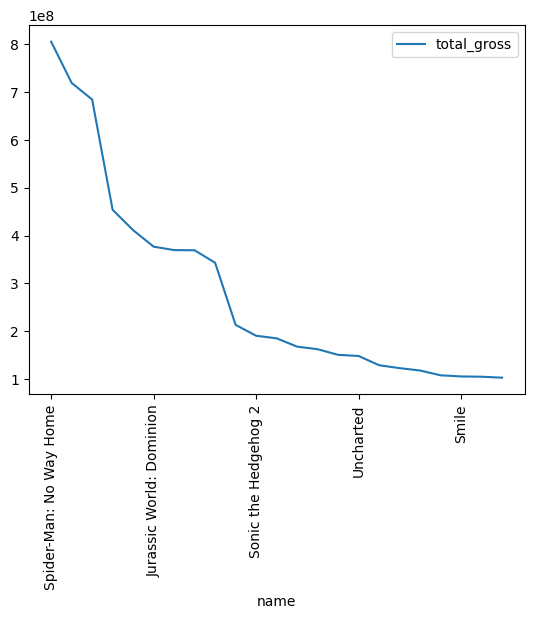

In [80]:
df[df.total_gross >= 100000000].plot(kind = "line", x = "name", y = "total_gross", rot=90)
plt.savefig("100mil_bar.png", bbox_inches="tight")

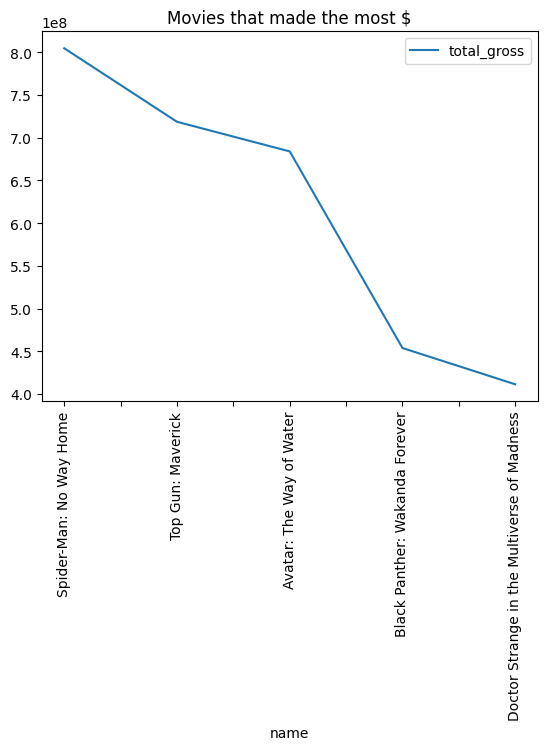

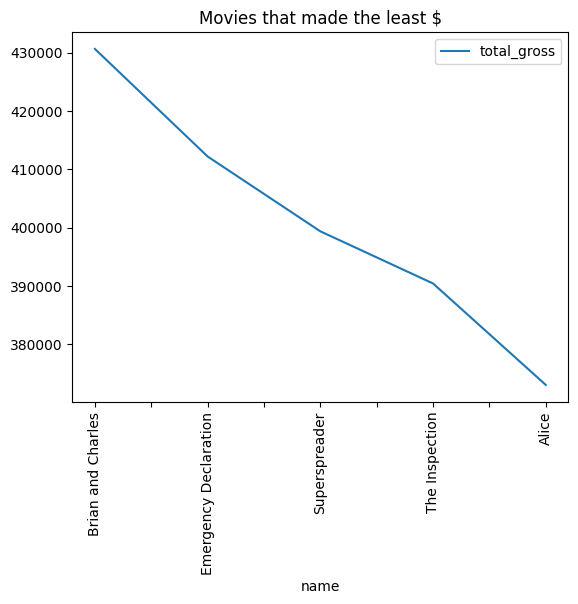

In [84]:
df[['name', 'total_gross']].head(5).plot(kind = 'line', x = 'name', y = 'total_gross', rot=90, title='Movies that made the most $')
plt.savefig("top_movies_line_graph.png", bbox_inches="tight")

df[['name', 'total_gross']].tail(5).plot(kind = 'line', x = 'name', y = 'total_gross', rot=90, title='Movies that made the least $')
plt.savefig("bottom_movies_line_graph.png", bbox_inches="tight")

In [60]:
top_ten_dist_group=df.groupby(["distributor"])["total_gross"].sum().sort_values(ascending=False).head(10)
grouped_df = top_ten_dist_group.to_frame()
grouped_df["total_gross"] = grouped_df["total_gross"].map('${:,.0f}'.format) #format total gross as currency
grouped_df #when looking at the chart below it seems like there is a major difference between the top 2 distributors and it is
#153,70 million

,total_gross
distributor,
Universal Pictures,"$1,753,457,650"
Sony Pictures Entertainment (SPE),"$1,599,755,287"
Walt Disney Studios Motion Pictures,"$1,494,523,251"
Paramount Pictures,"$1,304,200,550"
Warner Bros.,"$1,084,499,026"
20th Century Studios,"$878,158,897"
United Artists Releasing,"$161,900,624"
A24,"$143,261,545"
Focus Features,"$118,743,813"


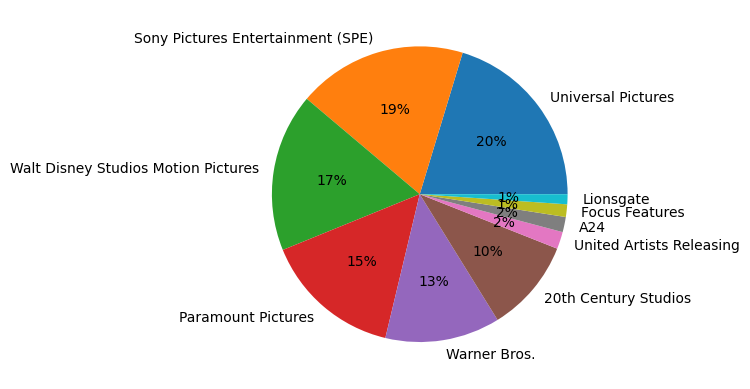

In [58]:
top_ten_dist_group.plot(kind="pie", autopct='%1.0f%%')

pylab.ylabel("")
plt.savefig("distributor_pie.png", bbox_inches="tight")
#but if we take a look at the proportion of the top 10 distributors then accordingly this 153 mil diff. results in only 1% dif 
#when looking at the top 10 distributors in a pie chart

In [7]:
from sqlalchemy import create_engine
import calendar

# Credentials to database connection
hostname="localhost"
dbname="final_project_python"
username="root"
password=""

engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=username, pw=password))

In [8]:
#create table if not exist. replace all data
df.to_sql("boxoffice", con=engine, index=False, if_exists="replace") #insert results to DB

200

,month,total_gross_sum
1,January,"$113,628,651"
2,February,"$384,189,110"
3,March,"$631,825,672"
4,April,"$573,293,367"
5,May,"$1,230,913,546"
6,June,"$752,745,697"
7,July,"$1,057,627,635"
8,August,"$258,538,665"
9,September,"$375,154,354"
10,October,"$752,855,648"


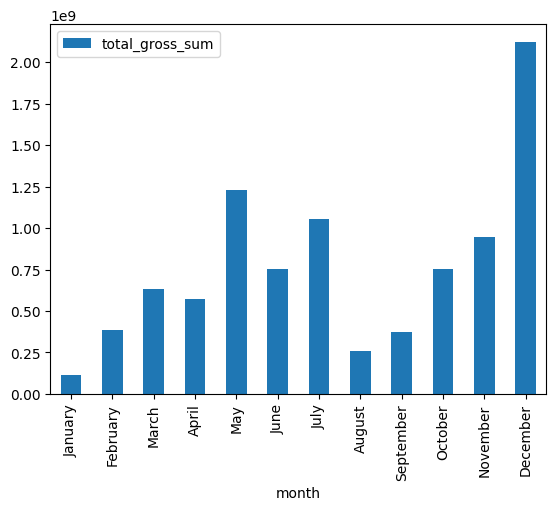

In [37]:
df_by_month = pandas.read_sql("""
select monthname(release_date) as month, sum(total_gross) as total_gross_sum
from boxoffice
group by monthname(release_date)
order by month(release_date)
""", engine) #query DB and group rows by release month

df_by_month.plot(kind = "bar", x = "month", y = "total_gross_sum", rot=90)

df_by_month["total_gross_sum"] = df_by_month["total_gross_sum"].map('${:,.0f}'.format) #format total gross as currency
df_by_month.index += 1 # to show first place with number 1

df_by_month